# Captcha Prediction - WIP

![test](https://camo.githubusercontent.com/fa7bac0f48f6da75b43ab069bc44f864d10f28c96fb713d9661d81ce48ed2224/687474703a2f2f677265677761722e636f6d2f63617074636861732e706e67)

Do you want a little bit more challenge than the traditional Image Classification. Let's see if we can classify a sequence of classes rather than a single one ;). 

In this blog post, I will try to break the captcha using 3 differents approaches.

__What is covered in the notebook__:
- Build captcha `Dataloaders` using Mid-level fastai API
- A simple tweak on the number of output can solve the problem
- An intuition about receptive field and why we should remove the `AdaptiveAvgPool2d` layer 
- A sequence should be solve by a sequential technique. Combining CNN + RNN -> CRNN with CTC Loss 


In [1]:
from fastai.vision.all import *
import PIL
from torch.nn import CTCLoss
from scipy.special import logsumexp  # log(p1 + p2) = logsumexp([log_p1, log_p2])

In [2]:
path = untar_data('https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip')

In [3]:
imgs = get_image_files(path)

In [4]:
imgs

(#1040) [Path('/home/ubuntu/.fastai/data/captcha_images_v2/by5y3.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/efb3f.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/76y6f.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/e2d66.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/c6we6.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/p2m6n.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/d66cn.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/2yggg.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/cffp4.png'),Path('/home/ubuntu/.fastai/data/captcha_images_v2/5npdn.png')...]

In [5]:
img = plt.imread(imgs[0])

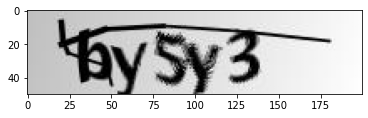

In [6]:
plt.imshow(img)

In [7]:
img.shape

(50, 200, 4)

In [8]:
path = imgs[0]

In [9]:
path

Path('/home/ubuntu/.fastai/data/captcha_images_v2/by5y3.png')

In [10]:
# Find all the unique labels
ld = set()
for f in imgs:
    for l in f.stem:
        ld.add(l)

label_mapper = "".join(sorted(ld))
l2i = { label_mapper[i]: i+1 for i in range(len(label_mapper)) } # labels to int + BLANK LABEL
i2l = { v: k for k, v in l2i.items() } # int to labels

In [11]:
l2i, i2l

({'2': 1,
  '3': 2,
  '4': 3,
  '5': 4,
  '6': 5,
  '7': 6,
  '8': 7,
  'b': 8,
  'c': 9,
  'd': 10,
  'e': 11,
  'f': 12,
  'g': 13,
  'm': 14,
  'n': 15,
  'p': 16,
  'w': 17,
  'x': 18,
  'y': 19},
 {1: '2',
  2: '3',
  3: '4',
  4: '5',
  5: '6',
  6: '7',
  7: '8',
  8: 'b',
  9: 'c',
  10: 'd',
  11: 'e',
  12: 'f',
  13: 'g',
  14: 'm',
  15: 'n',
  16: 'p',
  17: 'w',
  18: 'x',
  19: 'y'})

In [12]:
def label_func(path): return tensor([l2i[l] for l in path.stem])

In [13]:
def open_image(fname):
    img = PIL.Image.open(fname).convert('RGB')
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).double()/255.0

In [14]:
class CaptchaImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img,labels = self
        t = tensor(img)
        return show_image(t, title=''.join(str(i2l[i.item()]) for i in labels), ctx=ctx, **kwargs)

In [15]:
class CaptchaTransform(Transform):
    def __init__(self, files):
        self.files = files
        
    def encodes(self, i):
        file = self.files[i]
        label = label_func(file)
        img = open_image(file)
        return CaptchaImage(TensorImage(img), label)

In [16]:
bs = 8

In [17]:
splitter = RandomSplitter(valid_pct=0.1) 
train_idx , valid_idx = splitter(imgs) 
train_files = imgs[train_idx]
valid_files = imgs[valid_idx]
train_tl= TfmdLists(range(len(train_files)), CaptchaTransform(train_files))
valid_tl= TfmdLists(range(len(valid_files)), CaptchaTransform(valid_files))
dls = DataLoaders.from_dsets(train_tl, 
                             valid_tl, 
                             after_item=Resize((50,200), method=ResizeMethod.Squish),
                             after_batch=[Rotate(max_deg=10),
                                          Brightness(max_lighting=0.5, p=0.8, batch=False),
                                          Contrast(max_lighting=0.5, p=0.8, batch=False)], 
                             bs=bs)

In [18]:
@typedispatch
def show_batch(x:CaptchaImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): CaptchaImage(x[0][i],x[1][i]).show(ctx=ctx)

In [19]:
tensor(14).item()

14

In [20]:
one_batch = dls.one_batch()

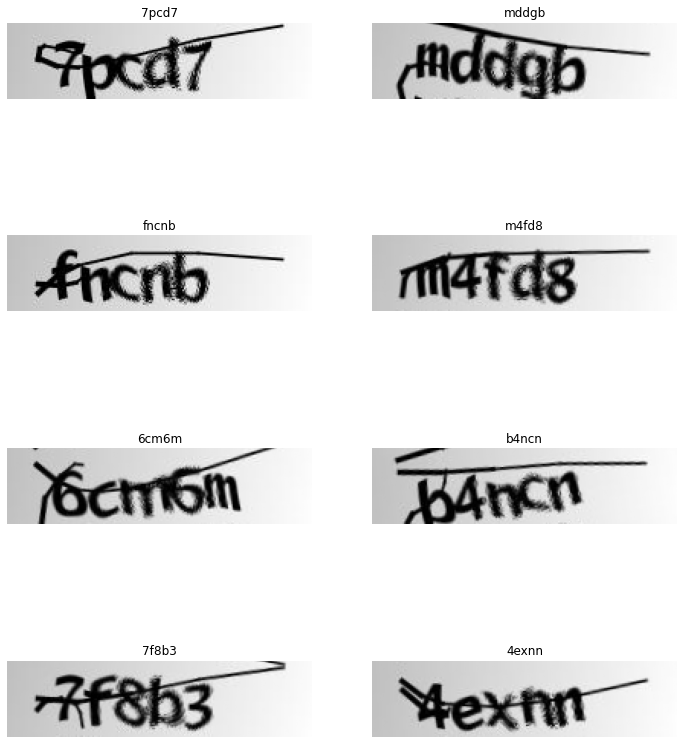

In [21]:
dls.show_batch(max_n=10)

In [22]:
n_chars = len(i2l)

In [23]:
n_chars * 5

95

## Simple Classification Model 

A simple image classification is used here with output dimension is: `Number_of_vocab x Number_of_characters`

In [24]:
n_class = n_chars + 1

In [25]:
model = create_cnn_model(xresnet34, n_class*5)

In [26]:
crit = LabelSmoothingCrossEntropyFlat()

In [27]:
def loss_captcha(output, target):
    output = output.view(-1, 5, n_class)
    return crit(output, target)

In [28]:
def char_accu(inp, targ, axis=-1):
    inps = inp.reshape(-1, 5, n_class)
    pred = inps.argmax(dim=-1)
    return (pred == targ).sum()/(pred.shape[0]*pred.shape[1])

In [29]:
def captcha_accu(inp, targ, axis=-1):
    inps = inp.reshape(-1, 5, n_class)
    pred = inps.argmax(dim=-1)
    return ((pred == targ).all(axis=1)).sum()/targ.shape[0]

In [30]:
learn = Learner(dls, model, loss_captcha, metrics=[char_accu, captcha_accu])

In [31]:
model = model.cuda()
dls = dls.cuda()

In [32]:
learn.fit_one_cycle(60, 3e-3)

epoch,train_loss,valid_loss,char_accu,captcha_accu,time
0,4.417060,3.768889,0.065385,0.000000,00:05
1,4.238056,5.701259,0.055769,0.000000,00:05
2,3.933014,3.674879,0.088462,0.000000,00:05
3,3.719078,5.090882,0.075000,0.000000,00:05
4,3.548473,3.824108,0.132692,0.000000,00:05
5,3.366105,3.826407,0.113462,0.000000,00:05
6,3.136746,3.577558,0.115385,0.000000,00:05
7,2.936203,3.092070,0.194231,0.000000,00:05
8,2.729806,3.936151,0.196154,0.000000,00:05
9,2.521348,4.372227,0.161538,0.000000,00:05


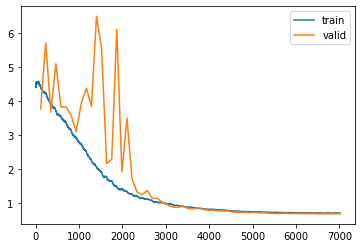

In [33]:
learn.recorder.plot_loss()

## No AvgPool

In the model used above, between the `body` and `head`, there is an `AvgPool2d` layer, which blurs all essential spatial information. So let's remove it and create our own `head`

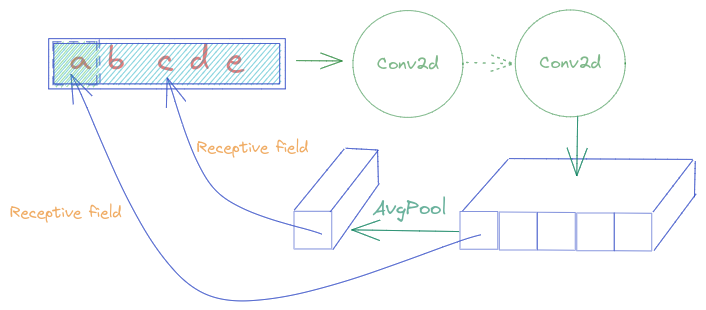

In [34]:
body = create_body(xresnet34)

In [35]:
head = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(7168,1000),
    nn.ReLU(),
    nn.BatchNorm1d(1000),
    nn.Dropout(0.5),
    nn.Linear(1000,n_class*5),
)

In [36]:
model = nn.Sequential(body, head)

In [37]:
model.cuda()
dls.cuda()

In [38]:
learn = Learner(dls, model, loss_captcha, metrics=[char_accu, captcha_accu])

In [39]:
learn.fit_one_cycle(60, 3e-3)

epoch,train_loss,valid_loss,char_accu,captcha_accu,time
0,3.056647,2.770755,0.221154,0.000000,00:06
1,2.707805,2.455260,0.351923,0.019231,00:06
2,2.307795,2.130244,0.434615,0.048077,00:06
3,1.944143,1.862135,0.544231,0.067308,00:06
4,1.663925,1.757791,0.603846,0.076923,00:06
5,1.499317,1.516997,0.653846,0.153846,00:06
6,1.436849,1.711082,0.590385,0.048077,00:06
7,1.486420,1.472152,0.676923,0.153846,00:06
8,1.389985,1.436426,0.725000,0.192308,00:06
9,1.344463,1.969319,0.588462,0.067308,00:06


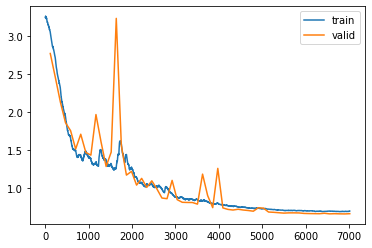

In [40]:
learn.recorder.plot_loss()

## CRNN + CTC Loss

In [41]:
body = create_body(resnet34, cut=7)

In [42]:
n_class = n_chars + 1

In [43]:
n_class

20

In [44]:
body(one_batch[0].cpu()).shape

torch.Size([8, 256, 4, 13])

In [63]:
class CRNN(nn.Module):
    def __init__(self, output_channel, H, W, n_class, map_to_seq_hidden=64, rnn_hidden_1=256, rnn_hidden_2=128):
        super(CRNN, self).__init__()
        self.body = create_body(resnet34, cut=7)
        self.map_to_seq = LinBnDrop(output_channel * H, map_to_seq_hidden, p=0.1, bn=False, lin_first=False)
        self.rnn1 = nn.LSTM(map_to_seq_hidden, rnn_hidden_1, bidirectional=True)
        self.rnn2 = nn.LSTM(2 * rnn_hidden_1, rnn_hidden_2, bidirectional=True)
        self.dense = LinBnDrop(2 * rnn_hidden_2, n_class, p=0.1, bn=False, lin_first=False)
        
    def forward(self, images):
        # shape of images: (batch, channel, height, width)

        conv = self.body(images)
        batch, channel, height, width = conv.size()

        conv = conv.view(batch, channel * height, width)
        conv = conv.permute(2, 0, 1)  # (width, batch, feature)
        seq = self.map_to_seq(conv)

        recurrent, _ = self.rnn1(seq)
        recurrent, _ = self.rnn2(recurrent)

        output = self.dense(recurrent)
        return output  # shape: (seq_len, batch, num_class)

In [64]:
output_channel = 256
H = 4
W = 13

In [65]:
model = CRNN(output_channel, H, W, n_class)

In [66]:
steps = W

In [67]:
criterion = nn.CTCLoss()

In [68]:
def loss_captcha_ctc(output, target):
    batch_size = target.shape[0]
    input_lengths = torch.LongTensor([steps] * batch_size)
    target_lengths = torch.LongTensor([5] * batch_size)
    log_probs = torch.nn.functional.log_softmax(output, dim=2)
    return criterion(log_probs, target, input_lengths, target_lengths)

### Metrics

In [69]:
blank = 0
beam_size = 10

In [70]:
NINF = -1 * float('inf')
DEFAULT_EMISSION_THRESHOLD = 0.01

In [71]:
def _reconstruct(labels, blank=0):
    new_labels = []
    # merge same labels
    previous = None
    for l in labels:
        if l != previous:
            new_labels.append(l)
            previous = l
    # delete blank
    new_labels = [l for l in new_labels if l != blank]
    return new_labels


In [72]:
def greedy_decode(emission_log_prob, blank=0, **kwargs):
    labels = np.argmax(emission_log_prob, axis=-1)
    labels = _reconstruct(labels, blank=blank)
    return labels

In [73]:
def beam_search_decode(emission_log_prob, blank=0, **kwargs):
    beam_size = kwargs['beam_size']
    emission_threshold = kwargs.get('emission_threshold', np.log(DEFAULT_EMISSION_THRESHOLD))

    length, class_count = emission_log_prob.shape

    beams = [([], 0)]  # (prefix, accumulated_log_prob)
    for t in range(length):
        new_beams = []
        for prefix, accumulated_log_prob in beams:
            for c in range(class_count):
                log_prob = emission_log_prob[t, c]
                if log_prob < emission_threshold:
                    continue
                new_prefix = prefix + [c]
                # log(p1 * p2) = log_p1 + log_p2
                new_accu_log_prob = accumulated_log_prob + log_prob
                new_beams.append((new_prefix, new_accu_log_prob))

        # sorted by accumulated_log_prob
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:beam_size]

    # sum up beams to produce labels
    total_accu_log_prob = {}
    for prefix, accu_log_prob in beams:
        labels = tuple(_reconstruct(prefix, blank))
        # log(p1 + p2) = logsumexp([log_p1, log_p2])
        total_accu_log_prob[labels] = \
            logsumexp([accu_log_prob, total_accu_log_prob.get(labels, NINF)])

    labels_beams = [(list(labels), accu_log_prob)
                    for labels, accu_log_prob in total_accu_log_prob.items()]
    labels_beams.sort(key=lambda x: x[1], reverse=True)
    labels = labels_beams[0][0]
    return labels


In [81]:
def prefix_beam_decode(emission_log_prob, blank=0, **kwargs):
    beam_size = kwargs['beam_size']
    emission_threshold = kwargs.get('emission_threshold', np.log(DEFAULT_EMISSION_THRESHOLD))

    length, class_count = emission_log_prob.shape

    beams = [(tuple(), (0, NINF))]  # (prefix, (blank_log_prob, non_blank_log_prob))
    # initial of beams: (empty_str, (log(1.0), log(0.0)))

    for t in range(length):
        new_beams_dict = defaultdict(lambda: (NINF, NINF))  # log(0.0) = NINF

        for prefix, (lp_b, lp_nb) in beams:
            for c in range(class_count):
                log_prob = emission_log_prob[t, c]
                if log_prob < emission_threshold:
                    continue

                end_t = prefix[-1] if prefix else None

                # if new_prefix == prefix
                new_lp_b, new_lp_nb = new_beams_dict[prefix]

                if c == blank:
                    new_beams_dict[prefix] = (
                        logsumexp([new_lp_b, lp_b + log_prob, lp_nb + log_prob]),
                        new_lp_nb
                    )
                    continue
                if c == end_t:
                    new_beams_dict[prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_nb + log_prob])
                    )

                # if new_prefix == prefix + (c,)
                new_prefix = prefix + (c,)
                new_lp_b, new_lp_nb = new_beams_dict[new_prefix]

                if c != end_t:
                    new_beams_dict[new_prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_b + log_prob, lp_nb + log_prob])
                    )
                else:
                    new_beams_dict[new_prefix] = (
                        new_lp_b,
                        logsumexp([new_lp_nb, lp_b + log_prob])
                    )

        # sorted by log(blank_prob + non_blank_prob)
        beams = sorted(new_beams_dict.items(), key=lambda x: logsumexp(x[1]), reverse=True)
        beams = beams[:beam_size]

    labels = list(beams[0][0])
    return labels


In [87]:
def captcha_accu_ctc(pred, targ, axis=-1):
    log_probs = torch.nn.functional.log_softmax(pred, dim=2)
    emission_log_probs = np.transpose(log_probs.detach().cpu().numpy(), (1, 0, 2))
    decoder = beam_search_decode
    label2char = i2l
    
    decoded_list = []
    for emission_log_prob in emission_log_probs:
        decoded = decoder(emission_log_prob, blank=blank, beam_size=beam_size)
        decoded_list.append(decoded)
    
    count_ok = 0
    for decode, gt in zip(decoded_list, targ):
        if len(decode) == len(gt):
            count_ok += (torch.tensor(decode).cuda() == gt).all().item()
            
    return count_ok/targ.shape[0]

In [83]:
# loss_captcha_ctc(pred, one_batch[1])

In [84]:
dls = dls.cuda()
model = model.cuda()

In [85]:
learn = Learner(dls, model, loss_func=loss_captcha_ctc, metrics=[captcha_accu_ctc])
# learn = Learner(dls, model, loss_func=loss_captcha_ctc)

In [86]:
learn.fit_one_cycle(1,1e-6)

epoch,train_loss,valid_loss,captcha_accu_ctc,time
0,0.001245,0.070678,0.961538,00:06


SuggestedLRs(valley=0.0014454397605732083)

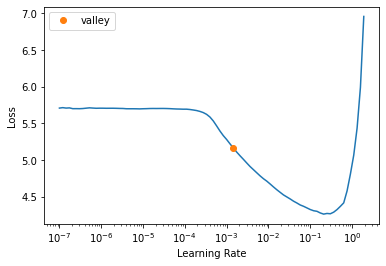

In [78]:
learn.lr_find()

In [79]:
learn.fit_one_cycle(60, 3e-3)

epoch,train_loss,valid_loss,captcha_accu_ctc,time
0,3.364362,3.221772,0.000000,00:05
1,3.239760,3.222240,0.000000,00:05
2,3.198520,3.179216,0.000000,00:05
3,3.068399,3.082180,0.000000,00:05
4,2.935494,2.940528,0.000000,00:05
5,2.778541,2.834429,0.000000,00:05
6,2.595863,2.414017,0.000000,00:05
7,2.398474,2.306193,0.000000,00:05
8,2.133149,2.030112,0.009615,00:05
9,1.933357,2.035026,0.000000,00:05


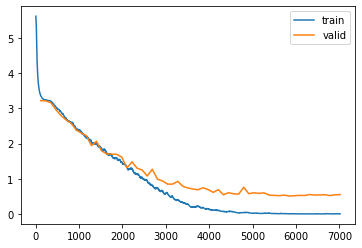

In [62]:
learn.recorder.plot_loss()